# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля. 

**В нашем распоряжении исторические данные:** технические характеристики, комплектации и цены автомобилей. 

**Цель исследования** — <u> построить модель для определения стоимости авто.</u> <a id='hypothesis'></a>

**Критерии, которые важны заказчику:**
- качество предсказания;
- время обучения модели;
- скорость предсказания модели.

**Исследование пройдёт в 6 основных этапов:**
 1. Обзор данных;
 2. Подготовка данных;
 3. Умножение матриц;
 4. Модели ML:
     - Обучение, 
     - Тестирование,
     - Анализ;
 6. Общий вывод.

## Обзор данных

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import re

In [2]:
# выведем первые 10 строк и общую информацию о df

df = pd.read_csv('/datasets/autos.csv')
display(df.head(10))
display(df.info())
df.describe()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Признаки:**

- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (лошадиные силы);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `NotRepaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты пользователя;
- `LastSeen` — дата последней активности пользователя.


**Целевой признак**
- `Price` — цена (евро)

In [3]:
# изучим уникальные значения в столбцах с типом данных 'object', но без дат:

print('Уникальные значения в столбцах:')
print()
for col in df.columns:
    
    print(col)
    display(np.sort(df[col].astype(str).unique()))
    print('Количество уникальных значений:', df[col].nunique())
    print('\n')

Уникальные значения в столбцах:

DateCrawled


array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'], dtype=object)

Количество уникальных значений: 271174


Price


array(['0', '1', '10', ..., '9997', '9998', '9999'], dtype=object)

Количество уникальных значений: 3731


VehicleType


array(['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small',
       'suv', 'wagon'], dtype=object)

Количество уникальных значений: 8


RegistrationYear


array(['1000', '1001', '1039', '1111', '1200', '1234', '1253', '1255',
       '1300', '1400', '1500', '1600', '1602', '1688', '1800', '1910',
       '1915', '1919', '1920', '1923', '1925', '1927', '1928', '1929',
       '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937',
       '1938', '1940', '1941', '1942', '1943', '1944', '1945', '1946',
       '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954',
       '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962',
       '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
       '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
      

Количество уникальных значений: 151


Gearbox


array(['auto', 'manual', 'nan'], dtype=object)

Количество уникальных значений: 2


Power


array(['0', '1', '10', '100', '1000', '10000', '1001', '1002', '1003',
       '1004', '1005', '101', '1011', '10110', '1012', '1016', '1017',
       '102', '1021', '10218', '1024', '103', '10311', '10317', '104',
       '105', '10520', '10522', '1054', '1055', '1056', '106', '1062',
       '107', '10710', '1079', '108', '1082', '109', '1090', '10910',
       '10912', '11', '110', '1100', '11011', '1102', '11025', '1103',
       '1105', '111', '1111', '11111', '1115', '112', '1120', '113',
       '114', '1149', '115', '11509', '1151', '11530', '1158', '116',
       '1160', '1162', '11635', '1164', '117', '118', '119', '1199', '12',
       '120', '1200', '12012', '1202', '121', '122', '1221', '1223',
       '123', '1230', '1239', '124', '1240', '1241', '125', '1250',
       '12510', '12512', '1252', '1256', '126', '12684', '127', '1275',
       '128', '1288', '129', '1299', '13', '130', '1300', '131', '1312',
       '1317', '132', '1324', '133', '1339', '134', '135', '1351', '136',
     

Количество уникальных значений: 712


Model


array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Количество уникальных значений: 250


Kilometer


array(['10000', '100000', '125000', '150000', '20000', '30000', '40000',
       '5000', '50000', '60000', '70000', '80000', '90000'], dtype=object)

Количество уникальных значений: 13


RegistrationMonth


array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

Количество уникальных значений: 13


FuelType


array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'nan', 'other',
       'petrol'], dtype=object)

Количество уникальных значений: 7


Brand


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Количество уникальных значений: 40


NotRepaired


array(['nan', 'no', 'yes'], dtype=object)

Количество уникальных значений: 2


DateCreated


array(['2014-03-10 00:00:00', '2015-03-20 00:00:00',
       '2015-06-18 00:00:00', '2015-08-07 00:00:00',
       '2015-08-10 00:00:00', '2015-09-04 00:00:00',
       '2015-09-09 00:00:00', '2015-11-02 00:00:00',
       '2015-11-08 00:00:00', '2015-11-10 00:00:00',
       '2015-11-12 00:00:00', '2015-11-17 00:00:00',
       '2015-11-23 00:00:00', '2015-11-24 00:00:00',
       '2015-12-05 00:00:00', '2015-12-06 00:00:00',
       '2015-12-17 00:00:00', '2015-12-27 00:00:00',
       '2015-12-30 00:00:00', '2016-01-02 00:00:00',
       '2016-01-03 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', '2016-01-08 00:00:00',
       '2016-01-10 00:00:00', '2016-01-13 00:00:00',
       '2016-01-15 00:00:00', '2016-01-16 00:00:00',
       '2016-01-17 00:00:00', '2016-01-18 00:00:00',
       '2016-01-19 00:00:00', '2016-01-20 00:00:00',
       '2016-01-22 00:00:00', '2016-01-23 00:00:00',
       '2016-01-24 00:00:00', '2016-01-25 00:00:00',
       '2016-01-26 00:00:00', '2016-01-27 00:0

Количество уникальных значений: 109


NumberOfPictures


array(['0'], dtype=object)

Количество уникальных значений: 1


PostalCode


array(['10115', '10117', '10119', ..., '99994', '99996', '99998'],
      dtype=object)

Количество уникальных значений: 8143


LastSeen


array(['2016-03-05 14:15:08', '2016-03-05 14:15:16',
       '2016-03-05 14:15:39', ..., '2016-04-07 14:58:49',
       '2016-04-07 14:58:50', '2016-04-07 14:58:51'], dtype=object)

Количество уникальных значений: 179150




In [4]:
# посмотрим количество и % nan'ов по столбцам

def nans(df):
    total_missing = df.isna().sum()
    percent_missing = df.isnull().sum() * 100 / len(df)


    missing_value_df = pd.DataFrame({'total_missing': total_missing,
                                    'percent_missing': percent_missing},
                                    index = df.columns)

    missing_value_df = missing_value_df.sort_values(by = 'percent_missing', ascending=False)

    display(missing_value_df.apply(pd.to_numeric).style.background_gradient(cmap='Reds'))
    
nans(df)

,total_missing,percent_missing
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


In [5]:
# сравним дублирующиеся строки

duplicates = df.duplicated(keep=False)
display( df.loc[duplicates].sort_values(["DateCrawled"]))
print(f'Количество дубликатов:\n{df.duplicated().sum()} - {round(df.duplicated().sum() / len(df) * 100, 3)}% от всех данных')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


Количество дубликатов:
4 - 0.001% от всех данных


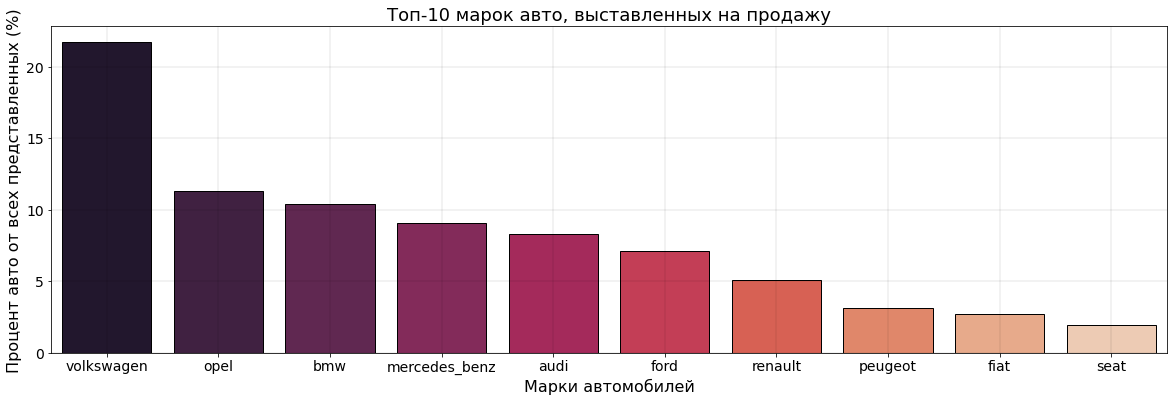

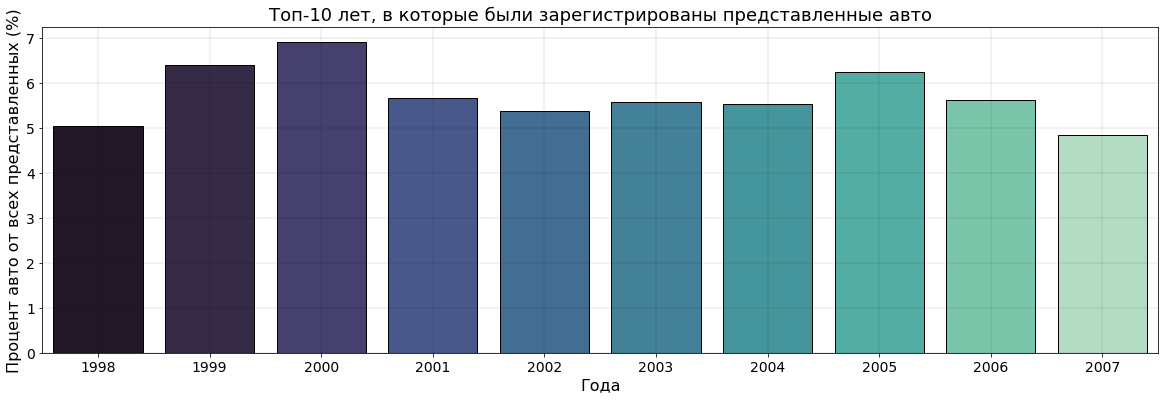

In [6]:
# посмотрим на топ-10 полпулярных марок и годов регистрации представленных авто 

func_share = lambda x: x.count() / len(df) * 100


for param, title, xlabel, palette in zip(['Brand', 'RegistrationYear'], 
                        ['марок авто, выставленных на продажу', 
                         'лет, в которые были зарегистрированы представленные авто'], 
                                         ['Марки автомобилей', 'Года'], 
                                         ['rocket', 'mako']):
    
    plt.figure(figsize = (20,6))
    ax = plt.gca()
    
    pivot = df.pivot_table(index=param, values='Price', 
                           aggfunc= func_share).sort_values(by='Price', ascending=False).head(10)

    sns.barplot(x = pivot.index, y = pivot['Price'], palette = palette, edgecolor ='black')

    plt.title('Топ-10 ' + title, fontsize=18)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Процент авто от всех представленных (%)',fontsize=16)
    plt.tick_params(labelsize = 14)
    plt.grid(linestyle='-', linewidth='0.1', color='black')

### Вывод

Нам предоставленны данные о 354364 автомобилях, выставленных на продажу, их владельцах и их анкетах на неком ресурсе, созданных с 2014 по 2016 гг. 

Мы не учли дублируеющиеся строки, т.к они являются явными дубликатами: несмотря на то, что у представленных авто нет уникальных идентификаторов, мы можем быть уверены, что в повторяющихся строках содержится дублирующаяся информация (у двух разных авто не могут совпадать столько разных призников: вряд ли двое пользователей с одинаковым почтовым индексом создадут идентичные анкеты об идентичных автомобилях в одно и то же время).

20% от всех автомобилей - машины марки "Volkswagen",  11% - "Opel", примерно 10% - "BMV", всего представлено 40 марок.
Большинство из представленных авто были зарегистрированы в период с 1999 по 2006 гг. 

К сожалению, данные представлены не в лучшем виде для дальнейшей работы с ними, а именно:
- мы имеем пропуски в столбцах: 
    - `NotRepaired` - 20%
    - `VehicleType` - 11%
    - `FuelType` - 9%
    - `Gearbox` - 6%
    - `Model` - 6%
- аномальные значения в столбцах:
    - `Price` - бесплатные машины;	
    - `RegistrationYear` - машины, зарегистрированные до момента изобретения автомобиля и авто из будущего;	
    - `Power` - автомобили с нулевыми, предельно низкими и высокими мощнастями;
    - `RegistrationMonth` - нулевой месяц в году.

Обратим внимание, что у всех авто нулевое количество фотографий (`NumberOfPictures`), этот признак бесполезен для обучения моделей. Также вряд ли моделям поможет информация из столбцов: `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` и `RegistrationMonth`.

На этапе предобработких данных мы:
1. Избавимся от неинформативных признаков;
2. Приведем названия столбцов в соответствие с хорошим стилем;
3. Постараемся обработать пропуски;
4. Попытаемся разобраться с аномалиями; 
5. Объявим fetures и target
6. Масштабируем признаки.


## Подготовка данных

### Удаление неинформативных признаков

In [7]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 
              'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)
df.sample(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
162099,5999,wagon,1977,manual,107,other,150000,petrol,ford,no
277285,1250,small,1999,manual,60,punto,150000,petrol,fiat,NaN
310204,795,sedan,1998,manual,80,other,90000,petrol,fiat,no


### Стиль заголовков

In [8]:
# вспомним как выглядят названия

df.columns.tolist()

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'NotRepaired']

In [9]:
# создадим список с новыми названиями, соответствующими хорошему стилю

columns = df.columns
new_columns = []

for col in columns:
    new_columns.append(re.sub(r'([A-Z])', r'_\1', col).lower()[1:])
new_columns

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'not_repaired']

In [10]:
# переименуем и выведем новые названия

df.rename(columns=dict(zip(columns, new_columns)), inplace=True)
df.columns.tolist()

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'not_repaired']

### Пропуски

#### `not_repaired` 

Мы помним, что пропусков в этом столбце больше всего, а именно - 20% от всех данных, поэтому избавиться от этих строк мы не можем. Заметим, что признак категориальный - "была машина в ремонте или нет", но смущает, что интерпритация и само название столбца противополжные по смыслу. У нас нет возможности обратиться с этим вопросом и узнать наверняка, но кажется более логичным предположить ошибку в переводе документации. В любом случае, в нашем исследовании это не имеет значения в рамках обучения моделей.

Достоверно заполнить пропуски, ориентируясь на другие столбцы, не представляется возможным: на этот признак влияют одновременно множество факторов: стаж водителя, стиль вождения, демографические факторы, технические характеристики, износ авто и множество других. 

Таким образом, даже если мы и выявим корреляцию с другим из представленных признаков она будет ничтожно мала и не факт, что достоверна. 

Заполним типом "unknown".

In [11]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')
df['not_repaired'].isna().sum()

0

#### `vehicle_type`

Можно предположить, что существует взаимосвязь между типом кузова и маркой автомобиля. 

Для наглядности выведем кросс таблицу для этих признаков.

In [12]:
def cross_tab(category_1, category_2):

    # создадим кросс-таблицу признаков
    cross_tab = pd.crosstab(index = df[category_1], columns = df[category_2])

    return cross_tab
    
    
cross_tab('model', 'vehicle_type')

vehicle_type,bus,convertible,coupe,other,sedan,small,suv,wagon
model,,,,,,,,
100,0,1,2,0,278,0,0,109
145,0,0,2,1,13,19,0,0
147,0,0,27,7,358,97,1,2
156,0,0,3,1,287,2,0,288
159,0,0,0,0,55,0,0,145
...,...,...,...,...,...,...,...,...
yaris,42,0,0,3,28,882,0,7
yeti,0,0,0,2,0,0,168,1
ypsilon,0,1,0,0,0,182,0,0


Взаимосвязь прослеживается: у каждой марки есть типы кузова - лидеры, которые чаще встречаются у таких машин.

Заполним пропуски в `vehicle_type` по марке автомобиля, у которой представлено больше всего машин с таким типом кузова. 

In [13]:
# напишем функцию, которая вернет максимальное значение из кросс-таблицы
def most_freq(crosstab):
    
    return crosstab.idxmax(axis=1)

# напишем функцию, которая заполнит пропуски по маркам, если марки нет - значением 'unknown'
def fill_na_by_model(data, col, crosstab):
    
    to_fill = data.groupby('model', dropna=False)[col].transform(lambda x: x.mode()[0])
    data[col] = data[col].fillna(to_fill)
    data[col] = data[col].fillna('unknown')
    
    return data

In [14]:
df = fill_na_by_model(df, 'vehicle_type', cross_tab('model', 'vehicle_type'))
df[['vehicle_type']].isna().sum()

vehicle_type    0
dtype: int64

#### `fuel_type`

In [15]:
cross_tab('model', 'fuel_type')

fuel_type,cng,electric,gasoline,hybrid,lpg,other,petrol
model,,,,,,,
100,0,0,15,0,8,0,359
145,0,0,1,0,0,0,43
147,0,0,133,0,18,0,390
156,0,0,189,0,15,0,366
159,0,0,140,0,0,0,58
...,...,...,...,...,...,...,...
yaris,0,0,95,19,0,0,867
yeti,0,0,84,0,0,0,87
ypsilon,0,0,6,0,1,0,179


In [16]:
# аналогично поступим с типом кузова

df = fill_na_by_model(df, 'fuel_type', cross_tab('model', 'fuel_type'))
df[['fuel_type']].isna().sum()

fuel_type    0
dtype: int64

#### `gearbox`

In [17]:
cross_tab('model', 'gearbox')

gearbox,auto,manual
model,,
100,63,336
145,0,40
147,29,520
156,45,556
159,26,183
...,...,...
yaris,91,912
yeti,31,142
ypsilon,14,185


In [18]:
# аналогично поступим с типом коробки передач

df = fill_na_by_model(df, 'gearbox', cross_tab('model', 'gearbox'))
df[['gearbox']].isna().sum()

gearbox    0
dtype: int64

#### `model`

In [19]:
# заполним пропуски на 'unknown'

df['model'].loc[df['model'].isna()] = 'unknown'
df['model'].isna().sum()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0

### Аномалии

Рассмотрим выбросы с помощью диаграммы размаха, для этого создадим функцию `anomalies_info(column, units)`:

In [20]:
# зададим функцию которая возращает границы "усов"
def det_mustache(column):
    
    q1 = df[[column]].quantile(.25)[column]
    q3 = df[[column]].quantile(.75)[column]

    iqr = q3 - q1
    
    left_mustache = round(q1 - 1.5 * iqr, 2)
    right_mustache = round(q3 + 1.5 * iqr, 2)

    if left_mustache < df[column].min(): left_mustache = df[column].min()  
    if right_mustache > df[column].max(): right_mustache = df[column].max()
        
    return [left_mustache, right_mustache]


# зададим функцию, которая строит 2 диаграммы размаха в разных масштабах и отражает границы "усов" - нормальных значений
def anomalies_info(column, units):
    
    fig, axes = plt.subplots(1,2, figsize=(20, 8))
    
    bplot1 = df.boxplot(column=column, ax = axes[0], patch_artist = True, boxprops=dict(facecolor='aliceblue'))
    plt.ylim(det_mustache(column)[0], det_mustache(column)[1]) 
    
    bplot2 = df.boxplot(column=column, ax = axes[1], patch_artist = True, boxprops=dict(facecolor='aliceblue'))
    
    fig.suptitle(f'Диаграмма размаха для признака {column}', fontsize = 18)
    
    axes[0].tick_params(labelsize = 15)
    axes[1].tick_params(labelsize = 15)
    
    axes[0].set_ylabel(units, fontsize = 15)
    
    plt.show() 
    
    df.loc[(det_mustache(column)[0] < df[column]) & (df[column] < det_mustache(column)[1])].hist(column=column, bins = 50, 
                                                      figsize = (10, 5), color = 'plum', edgecolor ='black')
    
    plt.title(f'Распределение признака {column}', fontsize = 16)
    plt.xlabel(units, fontsize = 13)
    plt.ylabel('Частота', fontsize = 13)
    plt.tick_params(labelsize = 13)
    
    plt.show() 
    
    display(df[column].describe())
    print('Границы "усов":', det_mustache(column)) 
    print('Согласно диаграмме размаха аномальные значения составляют {:.1%}'. format((len(df.loc[df[column] < det_mustache(column)[0]]) +
                                                           len(df.loc[df[column] > det_mustache(column)[1]])) /
                                                           len(df)) + ' от всей выборки')

#### `price`

Посмотрим, сколько бесплатных авто в нашей выборке:

In [21]:
print(f'Всего: {df.query("price == 0")["price"].count()}\nДоля: {round(func_share(df.query("price == 0")["price"]),2)} %')

Всего: 10772
Доля: 3.04 %


Прежде, чем анализировать выбросы избавимся от анкет с бесплатными авто, так как они исказят картинку и неинформативны для дальнейшей работы с моделями:

In [22]:
df = df.query('price > 0')

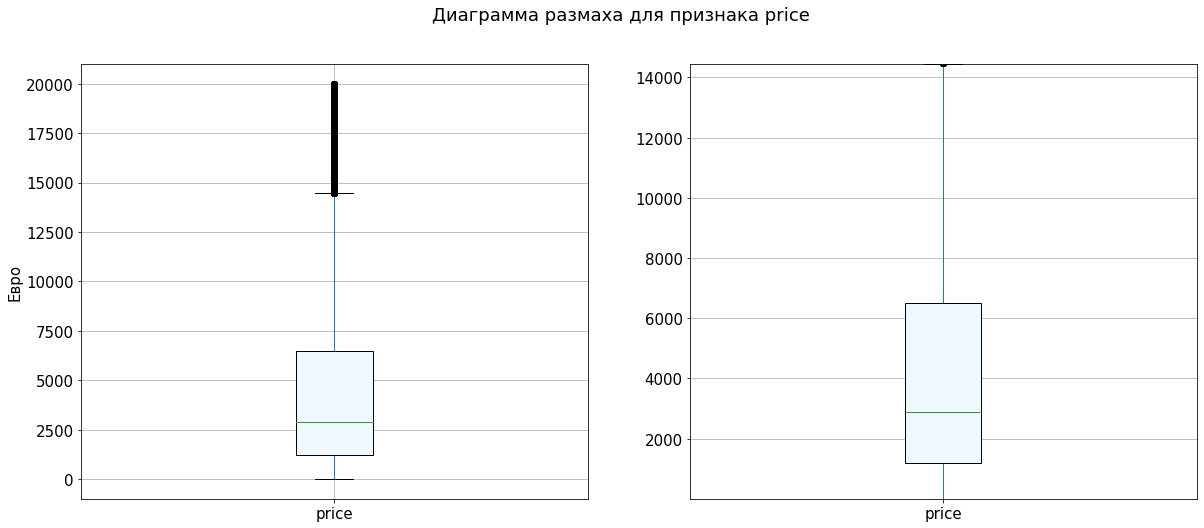

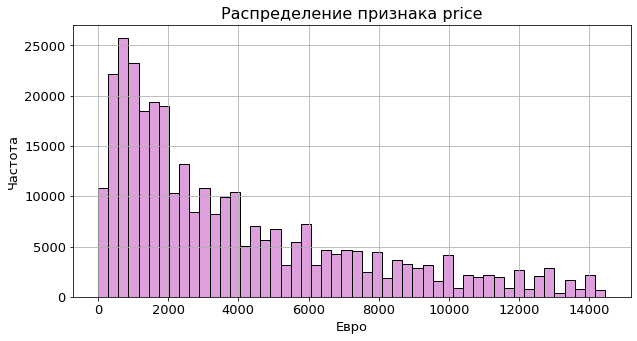

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Границы "усов": [1, 14450.0]
Согласно диаграмме размаха аномальные значения составляют 5.5% от всей выборки


In [23]:
anomalies_info('price', 'Евро') 

К сожалению, диаграмма размаха не дает нам четкого понимания, что можно считать выбросами, а что нет, ведь она считает нормальными предельно низкие цены, включая 1. Можем ли мы считать выбросами все цены выше 14450 евро - тоже вопрос, кажется, что даже максимальная цена 20 000 евро вполне реальна.

Наша теория о возникновении авто по предельно низким ценам:

вероятно, на маркетплейсе, с которого были выгружены анкеты, нет возможности проигнорировать поле со стоимостью авто. При этом не все продавцы готовы фиксировать ее, а открыты только к личному обсуждению с потенциальными покупателями. Либо они не могут самостоятельно дать оценку автомобилю, при этом не хотят обращаться к оценщикам. В связи с этим они указывают низкие цены, включая ноль, что расширяет воронку интересантов и поле для торга.

Будем считать, что цены ниже 100 евро относятся к описанным выше случаям.

Посмотрим, сколько в нашей выборке таких анкет:

In [24]:
print(f'Всего: {df.query("price < 100")["price"].count()}\nДоля: {round(func_share(df.query("price < 100")["price"]),2)} %')

Всего: 2542
Доля: 0.74 %


Избавляемся по той же причине, что и от бесплатных машин:

In [25]:
df = df.query('price >= 100')
df['price'].describe()

count    341055.000000
mean       4588.861052
std        4514.844700
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

#### `registration_year`

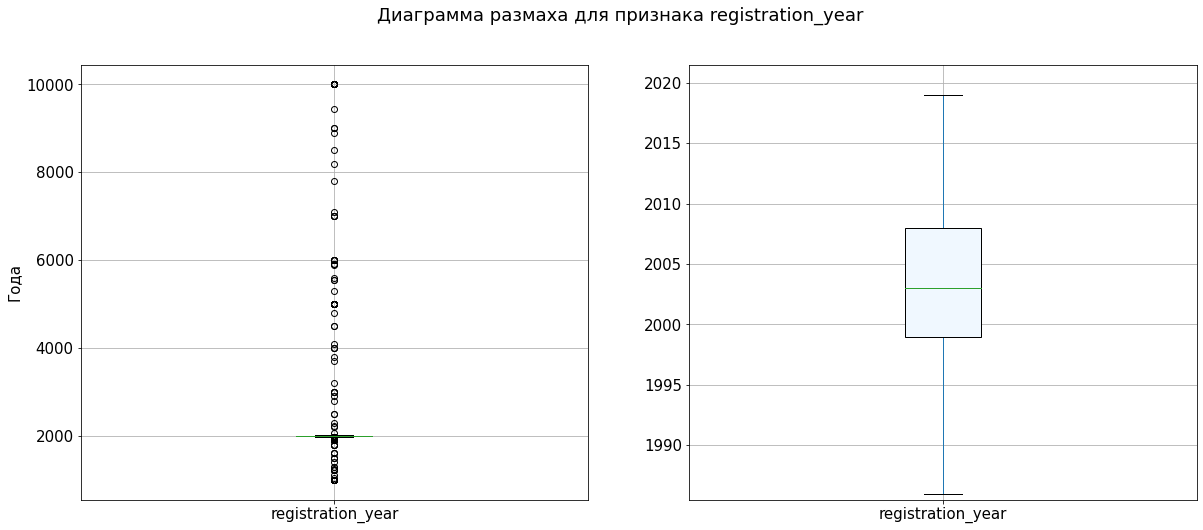

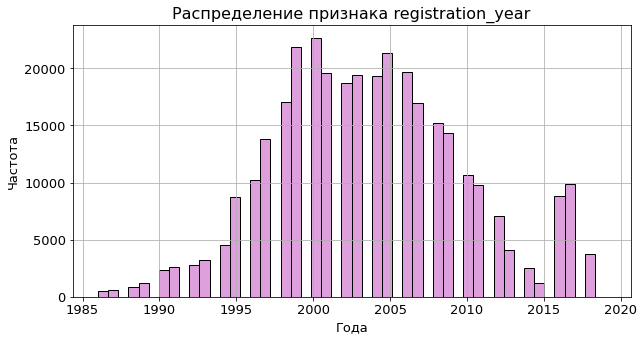

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Границы "усов": [1985.5, 2021.5]
Согласно диаграмме размаха аномальные значения составляют 1.6% от всей выборки


In [26]:
anomalies_info('registration_year', 'Года') 

В этом столбце выбросов гораздо меньше. Нам известно:
1. [Массовое производство автомобилей и их регистрация начались в 1990 г.](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F) 
2. Данные были выгружены в 2016 г.
Посмотрим, сколько имеем аномалий, исходя из этих условий:

Избавимся от неинформативных данных:

In [27]:
df = df[df['registration_year'].between(1990, 2016)]
df['registration_year'].describe()

count    318637.000000
mean       2003.240041
std           5.594180
min        1990.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

#### `power`

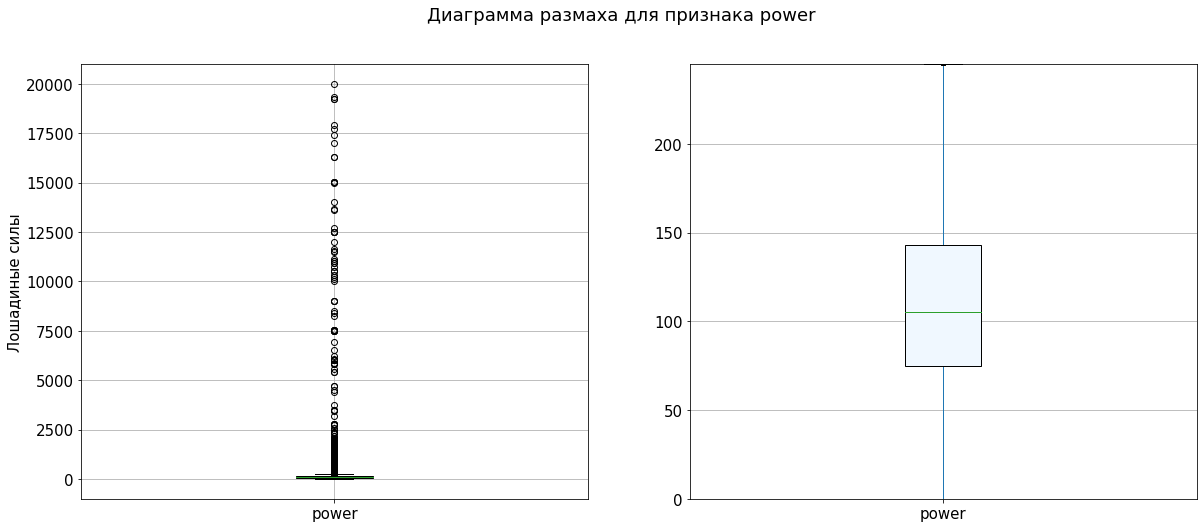

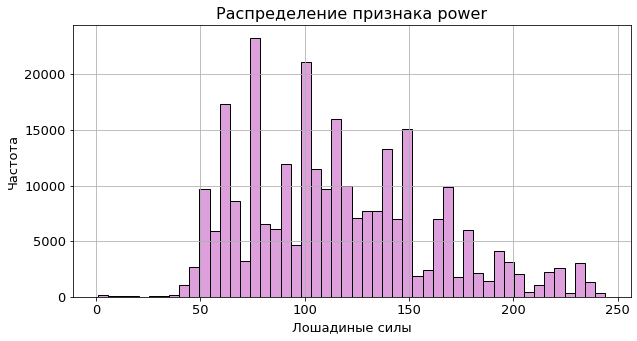

count    318637.000000
mean        112.997938
std         182.419977
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Границы "усов": [0, 245.0]
Согласно диаграмме размаха аномальные значения составляют 2.4% от всей выборки


In [28]:
anomalies_info('power', 'Лошадиные силы') 

In [29]:
print(f'Всего: {df.query("power == 0")["power"].count()}\nДоля: {round(func_share(df.query("power == 0")["power"]),2)} %')

Всего: 29827
Доля: 9.36 %


In [30]:
df = df[df['power'].between(20, 250)]
df['power'].describe()

count    281713.000000
mean        116.875632
std          45.434977
min          20.000000
25%          75.000000
50%         110.000000
75%         145.000000
max         250.000000
Name: power, dtype: float64

### Объявим fetures и target

In [31]:
# разделим на выборки

features = df.drop(['price'], axis=1)
target = df['price'] 

features_train_df, features_test_df, target_train, target_test = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state=12345)

In [32]:
for sample, sample_name in zip([features_train_df, features_test_df, target_train, target_test], ['features_train_df', 'features_test_df', 'target_train', 'target_test']):
    print(f'Выборка: {sample_name}')
    display(sample.head(5))
    print(f'Доля {sample_name} от df -', int((len(sample) / len(df))*100), '%')                                                    

Выборка: features_train_df


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
99166,small,2008,manual,55,fox,125000,petrol,volkswagen,no
351016,wagon,1998,manual,110,a4,150000,gasoline,audi,no
123153,small,2000,auto,41,fortwo,150000,gasoline,smart,no
221737,bus,2010,manual,100,other,50000,gasoline,peugeot,unknown
298941,wagon,2005,auto,218,unknown,150000,gasoline,bmw,no


Доля features_train_df от df - 74 %
Выборка: features_test_df


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
116637,small,2009,manual,97,fiesta,60000,petrol,ford,no
172390,bus,2006,manual,105,touran,150000,gasoline,volkswagen,no
119585,small,2008,manual,101,fiesta,150000,petrol,ford,no
325034,sedan,2002,manual,231,3er,150000,petrol,bmw,no
314921,small,2010,manual,105,a1,80000,gasoline,audi,no


Доля features_test_df от df - 25 %
Выборка: target_train


99166      2990
351016     1500
123153     1900
221737    10500
298941     7999
Name: price, dtype: int64

Доля target_train от df - 74 %
Выборка: target_test


116637    6800
172390    4999
119585    3666
325034    4200
314921    4000
Name: price, dtype: int64

Доля target_test от df - 25 %


### Прямое кодирование (OHE)

In [36]:
pd.set_option('max_columns', None)

In [37]:
features_train_ohe = pd.get_dummies(features_train_df, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_df, drop_first=True)

display(features_train_ohe.head())
features_test_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
99166,2008,55,125000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
116637,2009,97,60000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Масштабирование признаков

In [35]:
num_columns = [x for x in df.columns if df[x].dtype != 'object']
num_columns

['price', 'registration_year', 'power', 'kilometer']

In [36]:
num_columns = num_columns[1:]
num_columns

['registration_year', 'power', 'kilometer']

In [37]:
for ct in ['df', 'ohe']:
    scaler = StandardScaler()
    scaler.fit(globals()['features_train_%s' % ct][num_columns]) 
    
    for st in ['train', 'test']: 
        globals()['features_%s' % st + '_' + ct][num_columns] = scaler.transform(globals()\
                                                                                 ['features_%s' % st + '_' + ct][num_columns])
        pd.options.mode.chained_assignment = None
        print(f'features_{st}_{ct}')
        display(globals()['features_%s' % st + '_' + ct].head(3))

features_train_df


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
173729,wagon,0.333623,auto,2.862000,a6,0.59178,gasoline,audi,yes
230664,wagon,-0.280566,auto,1.174563,5er,0.59178,petrol,bmw,no
92734,wagon,-0.434114,manual,-0.337556,astra,0.59178,petrol,opel,no


features_test_df


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
195291,small,0.026528,manual,-1.060743,fusion,0.591780,gasoline,ford,no
201926,small,1.408453,manual,-0.907339,mii,-1.862490,petrol,seat,no
295754,bus,0.640717,auto,1.174563,touran,-0.089962,gasoline,volkswagen,no


features_train_ohe


,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
173729,0.333623,2.862000,0.59178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230664,-0.280566,1.174563,0.59178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
92734,-0.434114,-0.337556,0.59178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


features_test_ohe


,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
195291,0.026528,-1.060743,0.591780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201926,1.408453,-0.907339,-1.862490,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
295754,0.640717,1.174563,-0.089962,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Вывод

**На этапе предобработки данных мы:**
1. удалили неинформативные для обучения моделей признаки, такие как `NumberOfPictures`, `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen`, `RegistrationMonth`;
2. привели названия столбцов в соответствие с хорошим стилем;
3. избавились от пропусков в столбцах: `nkot_repaired`, `vehicle_type`, `fuel_type`, `gearbox`: все, что смогли - восстановили по маркам машин, остально заменили на "unknown", в `model` заменили на "unknown";
4. устранили аномальные значения, которые, скорее всего, произошли по вине пользователей: они либо случайно, либо намеренно указывали не истинные значения;
5. подготовили данные к обучению и тестированию моделей:
    - разбили на выбоки train и test (75 на 25% от df);
    - объвили features и target;
    - преобразовали категориальные признаки в численные методом OHE;
    - cтандартизировали данные.

**Таким образом на выходе мы имеем:**
- df без пропусков и с минимизированым количеством аномалий;

- `features_train_df`;
- `features_test_df`;
- `features_train_ohe`;
- `features_test_ohe`;
- `target_train`;
- `target_test`.

## Модели ML

### Обучение моделей

#### DecisionTreeRegressor

In [38]:
%%time

dtr = DecisionTreeRegressor(random_state=12345) 


param_grid = {'max_depth': [4],
             'min_samples_leaf': [4],
             'min_samples_split': range(2,10)}

CV_dtr = GridSearchCV(estimator = dtr, param_grid=param_grid, 
                          cv= 5, scoring = 'neg_root_mean_squared_error', verbose = 3) 
CV_dtr.fit(features_train_ohe, target_train)

print()
print(CV_dtr.best_params_)
print('RMSE = ', - CV_dtr.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.7s
[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.8s
[CV 3/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   2.2s
[CV 4/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.5s
[CV 5/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.5s
[CV 3/5] END max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.4s
[CV 4/5] END max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.4s
[CV 5/5] END max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.5s
[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4; total time=  

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


RMSE =  2508.6304210617445


CPU times: user 48.2 s, sys: 5.56 s, total: 53.8 s


Wall time: 53.9 s

#### LGBMRegressor

In [39]:
%%time

lgbmr = LGBMRegressor(random_state=12345, verbose = 3) 


param_grid = { 
    'max_depth': [3,8],
    'n_estimators': [100],
    'min_child_samples': [10]

}

CV_lgbmr = GridSearchCV(estimator=lgbmr, param_grid=param_grid, 
                          cv= 3, scoring = 'neg_root_mean_squared_error', verbose = 3) 
CV_lgbmr.fit(features_train_ohe, target_train)

print()
print(CV_lgbmr.best_params_)
print('RMSE = ', - CV_lgbmr.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.855863
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.395044
[LightGBM] [Debug] init for col-wise cost 0.092496 seconds, init for row-wise cost 0.007352 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 144166, number of used features: 300
[LightGBM] [Info] Start training from score 4713.074567
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree

{'max_depth': 8, 'min_child_samples': 10, 'n_estimators': 100}


RMSE =  1619.2704284669041


CPU times: user 52 s, sys: 1.67 s, total: 53.7 s


Wall time: 54.2 s

#### CatBoostRegressor

In [40]:
ob_columns = [x for x in df.columns if df[x].dtype == 'object']

cat_features = features_train_df[ob_columns]

In [41]:
cat_features = features_train_df[ob_columns]
cat_features = cat_features.columns.tolist()
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [42]:
%%time

cbr = CatBoostRegressor(random_state=12345, cat_features = cat_features) 


param_grid = { 
    'max_depth': [8,10],
    #'learning_rate':np.arange(0.1,1,0.2),
    'n_estimators': [1000]
}

CV_cbr_r = GridSearchCV(estimator=cbr, param_grid=param_grid, 
                          cv= 3, scoring = 'neg_root_mean_squared_error', verbose = 3) 
CV_cbr_r.fit(features_train_df, target_train)

print()
print(CV_cbr_r.best_params_)
print('RMSE = ', - CV_cbr_r.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Learning rate set to 0.089801
0:	learn: 4203.1869902	total: 353ms	remaining: 5m 52s
1:	learn: 3963.3347355	total: 611ms	remaining: 5m 4s
2:	learn: 3735.6355411	total: 956ms	remaining: 5m 17s
3:	learn: 3534.1976534	total: 1.24s	remaining: 5m 8s
4:	learn: 3347.0388838	total: 1.46s	remaining: 4m 49s
5:	learn: 3183.0195352	total: 1.7s	remaining: 4m 41s
6:	learn: 3033.4590331	total: 1.91s	remaining: 4m 31s
7:	learn: 2897.8729674	total: 2.15s	remaining: 4m 26s
8:	learn: 2779.8586988	total: 2.4s	remaining: 4m 24s
9:	learn: 2669.4626655	total: 2.69s	remaining: 4m 25s
10:	learn: 2571.8415906	total: 2.91s	remaining: 4m 21s
11:	learn: 2490.1075606	total: 3.25s	remaining: 4m 27s
12:	learn: 2414.6038277	total: 3.52s	remaining: 4m 27s
13:	learn: 2341.4302993	total: 3.75s	remaining: 4m 24s
14:	learn: 2279.0839888	total: 3.99s	remaining: 4m 21s
15:	learn: 2225.1344720	total: 4.28s	remaining: 4m 23s
16:	learn: 2171.6732299	total: 4.54s	remainin

{'max_depth': 10, 'n_estimators': 1000}


RMSE =  1481.5640605707367


CPU times: user 37min 13s, sys: 8.02 s, total: 37min 21s


Wall time: 37min 42s

### Тестирование моделей

#### DecisionTreeRegressor

In [43]:
%%time

dtr_predictions = CV_dtr.best_estimator_.predict(features_test_ohe)

CPU times: user 91 ms, sys: 71.7 ms, total: 163 ms
Wall time: 161 ms


In [44]:
print('RMSE = ', mean_squared_error(dtr_predictions, target_test)** .5)

RMSE =  2507.965642094621


#### LGBMRegressor

In [45]:
%%time

lgbmr_predictions = CV_lgbmr.best_estimator_.predict(features_test_ohe)

CPU times: user 837 ms, sys: 67.4 ms, total: 904 ms
Wall time: 848 ms


In [46]:
print('RMSE = ', mean_squared_error(lgbmr_predictions, target_test)** .5)

RMSE =  1608.1025648545092


#### CatBoostRegressor

In [53]:
%%time

cbr_predictions = CV_cbr_r.best_estimator_.predict(features_test_df)

CPU times: user 1.11 s, sys: 3.95 ms, total: 1.12 s
Wall time: 1.12 s


In [48]:
print('RMSE = ', mean_squared_error(cbr_predictions, target_test)** .5)

RMSE =  1463.1315460313103


### Анализ моделей

| Модель | RMSE | Время обучения (минуты) | Время предсказания (секунды)|
| ------- | -------- | ------- | -------- |
| DecisionTreeRegressor   | 2508    | 0,3   | 0,161    |
| LGBMRegressor   | 1608    | 0,3   | 0,848    |
| CatBoostRegressor   | 1463    | 13   | 1,12    |

Так как при обучении моделей мы использовали 3-кратную кросс-валидацию, время обучения делим на 3.

In [57]:
# добавим столбец с ценовыми категориями
test_df['price_category'] = pd.cut(test_df['price'], bins = range(100, 20000, 200))

# добавим столбец с ошибками предсказания моделей
test_df['cbr_rmse'] = np.abs(cbr_predictions - target_test)
test_df['lgbmr_rmse'] = np.abs(lgbmr_predictions - target_test)

# добавим столбец с долями этих ошибок в процентах
test_df['cbr_rmse_perc'] = test_df['cbr_rmse'] / test_df['price'] *100
test_df['lgbmr_rmse_perc'] = test_df['lgbmr_rmse'] / test_df['price'] *100

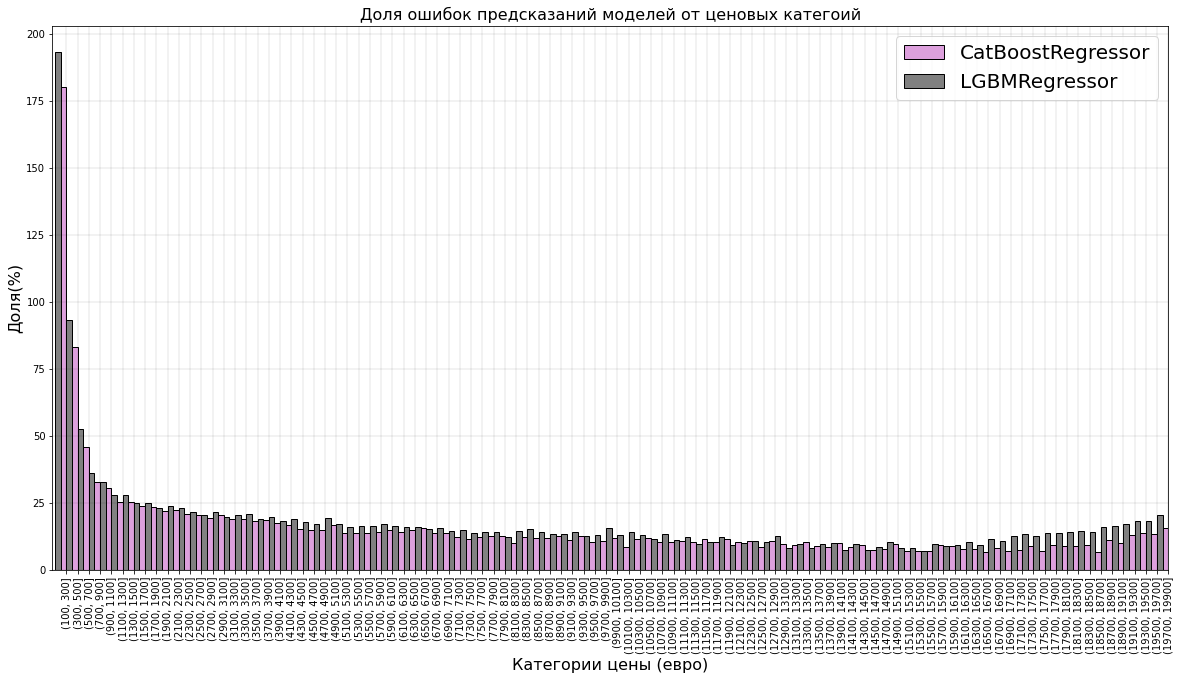

In [81]:
# построим график для двух лучших моделей, отражающий доли ошибок предсказаний от ценовых категорий

plt.figure(figsize=(20,8))
ax = plt.gca()

legend_list = ['CatBoostRegressor', 'LGBMRegressor']

for col, color, position in zip(['cbr_rmse_perc', 'lgbmr_rmse_perc'], ['plum', 'gray'], [1,2]):

    test_df.groupby('price_category').agg('median')[col].plot(kind = 'bar', figsize = (20,10), 
                                                              ax=ax, color = color, width=0.5, 
                                                              position=position, 
                                                              edgecolor ='black')

    

ax.legend(legend_list, fontsize = 20)
plt.title('Доля ошибок предсказаний моделей от ценовых категоий', fontsize = 16)
plt.xlabel('Категории цены (евро)', fontsize = 16)
plt.ylabel('Доля(%)', fontsize = 16)    

plt.grid(linestyle='-', linewidth='0.1', color='black')

plt.show()

### Вывод

Для заказчика в совокупности важны:
- время обучения, 
- время предсказания,
- качество моделей.

Опираясь на совокупность этих параметров выберем LGBMRegressor с гиперпараметрами max_depth = 8, min_child_samples = 10, n_estimators = 100. Она значительно опережает по качеству дерево (RMSE меньше на 900) и по времени обучения CatBoost (на 13 минут).

Также стоит обратить внимание заказчика, что наша модель `CV_lgbmr` пригодна не для всех ценовых категорий машин. Например для машин до 1000 евро ошибка сопоставима и иногда превышает саму цену. Если для заказчика ошибка до 25% от цен приемлема, то он сможет предсказывать стоимость машин от 1500 евро, а лучшие предсказания будут для машин от 10 - 15 тыс евро, ошибка будет в райное 100 евро.

## Вывод

1. Мы изучили предоставленны данные о 354364 автомобилях, выставленных на продажу, их владельцах и их анкетах на неком ресурсе, созданных с 2014 по 2016 гг. 
2. Выявили аномалии и пропуски, природа которых человеческий фактор, некоторые характеристики пользователи интернет-ресурса ошибочно или намеренно искажали, например, чтобы не указывать цену автомобиля, выставленного на продажу, писали "0".

3. На этапе предобработких данных мы:
    - избавились от неинформативных признаков, например, дата скачивания анкеты из базы или почтовый индекс владельца анкеты (такая информация исказит работу моделей;
    - привели названия столбцов в соответствие с хорошим стилем;
    - избавились от пропусков: некоторые постарались восстановить по марке машин (например, тип кузова и топлива), указав самое распространенное значение у машин этой марки. Остальные значения заменили на 'unknown';
    - удалили аномальные зачения, ориентируясь на общедоступные факты (диаграмма размаха в нашем случае оказалась неинформативной); 
    - разбили данные на выбоки train и test (75 на 25% от df);
    - объвили features и target;
    - преобразовали категориальные признаки в численные методом OHE;
    - cтандартизировали данные.
4. Обучили 3 вида моделей: DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor. Наилучшее качество (RMSE = 1463) дал CatBoost, однако обучался при этом примерно 13 минут. Далее по качеству идет LGBMRegressor (RMSE = 1608), обучился за 18 с, предсказал меньше, чем за секунду. Дерево хоть и стало самой быстрой моделью, качество его оставляет желать лучшего: в среднем дает ошибку на 2508 евро.


Таким образом, компании «Не бит, не крашен» **мы рекомендуем использовать нашу модель `CV_lgbmr` с гиперпараметрами max_depth = 8, min_child_samples = 10, n_estimators = 100. Она обучилась за 18 с, предсказала за 0,8 секунд и дает RMSE = 1608.  Если для заказчика ошибка до 25% от цен приемлема, то он сможет предсказывать стоимость машин от 1500 евро, а лучшие предсказания будут для машин от 10 - 15 тыс евро, ошибка будет в райное 100 евро. Для машин ценовых категорий до 1000 евро модель бесполезна.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей